In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import random

from skimage.transform import resize
import numpy as np
import tensorflow as tf
import gym

env_name = "Skiing-v0"
env = gym.make(env_name)

In [2]:
def render(x, step=0):
    display.clear_output(wait=True)

    plt.figure(figsize=(6, 6))
    plt.clf()
    plt.axis("off")
    plt.title("step: %d" % step)
    plt.imshow(x, cmap=plt.cm.gray)
    plt.pause(0.001)   # pause for plots to update
  
def pre_processing(observe):
    processed_observe = resize(observe[54:-52,8:152], (64, 64), mode='reflect', anti_aliasing=True)
    return processed_observe
  
def batch(batch_size=32):
  n_data = len(obss)
  ids = np.random.choice(n_data, batch_size, replace=False)
  b_o = obss[ids]
  b_a = acts[ids]
  return b_o, b_a

def model(x, name='policy'):
  with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
    x = tf.layers.conv2d(x, 16, 8, strides=4, activation=tf.nn.relu)
    x = tf.layers.conv2d(x, 32, 4, strides=2, activation=tf.nn.relu)
    x = tf.layers.conv2d(x, 64, 3, strides=1, activation=tf.nn.relu)
    x = tf.layers.flatten(x)
    x = tf.layers.dense(x, 512, activation=tf.nn.relu)
    x = tf.layers.dense(x, 3)
  return x

In [3]:
# Objects can be distinquished by RGB codes.
# Player: [214, 92, 92]
# Flags (blue): [66, 72, 200]
# Flags (red): [184, 50, 50]

def get_pos_player(observe):
  ids = np.where(np.sum(observe == [214, 92, 92], -1) == 3)
  return ids[0].mean(), ids[1].mean()

def get_pos_flags(observe):
  if np.any(np.sum(observe == [184, 50, 50], -1) == 3):
    ids = np.where(np.sum(observe == [184, 50, 50], -1) == 3)
    return ids[0].mean(), ids[1].mean()
  else:
    base = 0
    ids = np.where(np.sum(observe[base:-60] == [66, 72, 200], -1) == 3)
    return ids[0].mean() + base, ids[1].mean()

def get_speed(observe, observe_old):
  min_val = np.inf
  min_idx = 0
  for k in range(0, 7):
    val = np.sum(np.abs(observe[54:-52,8:152] - observe_old[54+k:-52+k,8:152]))
    if min_val > val:
      min_idx = k
      min_val = val
  return min_idx

### Hparams & Data containers

In [4]:
n_cont = 4
obss = np.empty((0, 64, 64, 3*n_cont))
acts = np.empty((0))

### Models

In [5]:
x = tf.placeholder(tf.float32, (None, 64, 64, 3*n_cont))
y = tf.placeholder(tf.int32, (None))
y_onehot = tf.one_hot(y, 3)

y_hat = model(x)
p_hat = tf.nn.softmax(y_hat)

In [6]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_onehot, logits=y_hat))
opt = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [7]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

### Train

In [8]:
for episode in range(1000):
  observe = env.reset()
  step = 0
  cnt = 0
  done = False
  r_a, c_a = get_pos_player(observe)
  r_f, c_f = get_pos_flags(observe)
  r_a_old, c_a_old = r_a, c_a
  observe_old = observe
  history = np.concatenate([pre_processing(observe)] * n_cont, -1)

  outs_o = []
  outs_a = []
  while not done:
    step += 1

    # TEACHER
    v_f = np.arctan2(r_f - r_a, c_f - c_a) # direction from player to target
    spd = get_speed(observe, observe_old)
    v_a = np.arctan2(spd, c_a - c_a_old) # speed vector of the player
    r_a_old, c_a_old = r_a, c_a
    observe_old = observe
    if spd == 0 and (c_a - c_a_old) == 0:
      # no movement
      cnt += 1
      act_t = np.random.choice(3, 1)[0]
    else:
      cnt = 0
      if v_f - v_a < -0.1:
        act_t = 1
      elif v_f - v_a > 0.1:
        act_t = 2
      else:
        act_t = 0

    if cnt > 10:
      print('no movement!')
      break
    
    outs_o.append(history)
    outs_a.append(act_t)
    
    p = sess.run(p_hat, feed_dict={x: [history]})[0]
    act = np.random.choice(3, 1, p=p)[0]
    observe, reward, done, info = env.step(act)
    history = np.concatenate([pre_processing(observe), history[:,:,3:]], -1)
    r_a, c_a = get_pos_player(observe)
    r_f, c_f = get_pos_flags(observe)
  
  # append data & limit data size
  obss = np.concatenate([obss, outs_o], 0)
  acts = np.concatenate([acts, outs_a], 0)
  if len(obss) > 5000:
    obss = obss[-5000:]
    acts = acts[-5000:]

  for i in range(500):
    d_x, d_y = batch()
    ret = sess.run([opt, loss], feed_dict={x: d_x, y: d_y})
    print('%5d %5d' % (episode, i), ret[1], end='\r')
  print()

no movement!
    0   499 0.60452415 0.4936602 0.6065197 0.46410808 0.5401985 0.53827786 0.69596416 0.561501 0.21409085 0.46556175 0.60959953 0.32170627 0.6142197 0.23219566 0.37988564 0.54325366 0.54687876 0.3853893 0.392959360.7781103 0.6857763 0.46332198 0.38827407 0.54356680.54030895 0.5367163 0.5353128 0.6150607 0.41205916 0.61783165 0.4594453 0.6840366 0.5381674 0.37610537 0.5936764 0.46036512 0.46712196
no movement!
    1   499 0.77403395 0.89815915 0.96912384 0.8728646 1.0275073 0.8064497 0.9491984 0.9513556 1.0718882 1.0029067 0.8935598 1.0180036 0.9600648 0.83404046 0.88760656 0.93255436 1.058966 1.0451186 0.8595232 0.909232 0.7942778 0.90562564 0.921555 0.93709743 0.8330091 1.0200737 0.89572024 0.9726998 0.8971298 0.71585643 0.81752175 0.7539636 0.8438501 0.8837948 0.9350308 0.74094 0.87932897
no movement!
    2   499 0.51558836 0.687268 0.8374928 0.77996063 0.9111794 0.9201267 0.7464491 1.0054731 0.7815519 0.7404498 0.80692935 0.7220453 0.6794003 0.73352814 0.6944359 0.77939

   20   499 0.55746853 0.59338987 0.71802175 0.9066852 0.93126905 0.7375978 0.67025495 0.8057046 0.7906474 0.47159597 0.77957416 0.54884195 0.5629281 0.63645315 0.5766698 0.6848281 0.70015734 0.66126525 0.4078686 0.73058045 0.5498506 0.66518927 0.8473841 0.81757325 0.50275326 0.5606734 0.50660485 0.57391036 0.927687 0.79427004 0.8698518 0.65295184 0.64486724 0.6761552 0.6470904
no movement!
   21   499 0.85364664 0.45699754 0.8082835 0.49691588 0.6947977 0.5586018 0.79731184 0.7760316 0.6838438 0.81914353 0.66980773 0.519665 0.6315026 0.55515754 0.95087135 0.8030696 0.60643566 0.7958033 0.7164537 0.6127904 0.5184755 0.7962899 0.73465407 0.53782594 0.6635779 0.75857145 0.90707076 0.73552024 0.6263154 0.54052234 0.86311656 0.7097216 0.5945025 0.6262183 0.57100236 0.659757 0.64876544
no movement!
   22   499 0.70607035 0.6626016 0.7505324 0.706622 0.75641626 0.5866543 1.0707908 0.6880547 0.60654205 0.636503 0.667598 0.7208639 0.58054435 0.69534034 0.90034544 0.92425984 0.5914974 0.7079062

   40   499 0.57392364 0.86104697 0.6058713 0.50499105 0.6108083 0.82331810.6665237 0.7171389 0.703102 0.8682076 0.6359348 0.76184297 0.657899 0.88268507 0.54105514 0.5712693 0.7136512 0.6017989 0.6199657 0.82336044 0.66992724 0.69487435 0.85934085 0.72049314 0.60849667 0.6005763 0.70771563 0.4963924 0.89301825 0.727502 0.47169924 0.73432356 0.8675934 0.6272999 0.5171156
no movement!
   41   499 0.58726235 0.72765523 0.5163944 0.7748412 0.62884736 0.9949355 0.77553356 0.70316696 0.60282576 0.6717824 0.7916573 0.6435563 0.67434126 0.88451225 0.65905416 0.6224926 0.73943996 0.7351069 0.5860045 0.7139622 0.49100506 0.93976665 0.752714 0.7214718 0.8196878 0.6508061 0.7402073 0.8542637 0.7478319 0.5463457 0.65716726 0.7204522 0.8135636 0.72596514 0.6934806 0.892703
no movement!
   42   499 0.74815255 0.7789071 0.68319243 0.6174675 0.6633315 0.81906056 0.8643847 0.765157 0.6315446 0.7915733 0.66896427 0.47632188 0.58673424 0.74701816 0.9136924 0.646176 0.7092407 0.60619736 0.5930569 0.660955

   61   499 0.59041643 0.5733066 0.5778729 0.56869584 0.8680141 0.49654037 0.6912045 0.66570437 0.7550748 0.73577696 0.70245826 0.69095653 0.4852409 0.5330962 0.56704295 0.57249475 0.48899513 0.6197263 0.7045454 0.53393644 0.46814942 0.4362322 0.55183446 0.6150358 0.62568855 0.7244711 0.5030232 0.6815588 0.6198392 0.5369135 0.37740213 0.69129574 0.37607512 0.6121829 0.81619847 0.6209967
no movement!
   62   499 0.54715526 0.44521874 0.7318863 0.75825620.5818182 0.6701384 0.6596959 0.5556669 0.55967784 0.5996971 0.68971956 0.6251805 0.57350886 0.65012616 0.56285155 0.35375458 0.4754434 0.42442963 0.81912190.81558967 0.4842259 0.45171613 0.5756072 0.6635376 0.5947392 0.8040711 0.45630938 0.64425206 0.498386 0.74609613 0.64523846 0.4651378 0.931716 0.7125097 0.5905941 0.5990411 0.72755384
no movement!
   63   499 0.59795474 0.7265285 0.5561931 0.4673898 0.561114 0.551369 0.6541008 0.7214097 0.50514007 0.7225824 0.6966685 0.551788 0.5706918 0.59411126 0.50378835 1.0922899 0.8592566 0.76090

   81   499 0.58703466 0.52739316 1.0057368 0.8223935 0.9918524 0.3890391 0.7216625 0.6339493 0.884549 0.5983412 0.6732381 0.8231109 0.713068 0.8193556 0.59869194 0.77941954 0.9079934 0.617494 0.5713304 0.508368 0.6815017 0.66148204 0.600602 0.6983328 0.56918603 0.62698233 0.74776566 0.60216075 0.9405995 0.8111203 0.6801223 0.68283296 0.8081742 0.5937589 0.48533836
no movement!
   82   499 0.63432187 0.7262431 0.57598346 0.621142 0.9022378 0.42629373 0.57559466 0.8284563 0.7561902 0.61359584 0.7246131 0.53884816 0.714633 0.6149757 0.5246637 0.7017909 0.5382079 0.65464485 0.5128968 0.5248617 0.6942677 0.8358261 0.7678865 0.8758397 0.7852638 0.73178566 0.53160644 0.7084801 0.6326954 0.6493829 0.61547756 0.54367423 0.76042235 0.81751615 0.68108344 0.8385942 0.619641960.5898497 0.66040146
no movement!
   83   499 0.73072346 0.71600616 0.75424266 0.54260814 0.56017435 0.55244166 0.65664077 0.7020115 0.6870922 0.6370914 0.6498037 0.80097544 0.96399987 0.5748087 0.6775465 0.6037276 0.74482155

  101   499 0.47575943 0.7516366 0.316319470.74387926 0.769845 0.9105599 0.6286467 0.6046775 0.9626787 0.38481572 0.5859901 0.9019194 0.6457937 0.43795186 0.62653816 0.90676737 0.6374212 0.60818315 0.6784642 1.0731559 0.46167332 0.362982060.5973104 0.50131685 0.5773127 0.63933 0.74892545 0.7263231 0.7026491 0.8346983 0.6728927 0.5850997 0.5926317 0.63126296 0.6854936 0.62752235
no movement!
  102   499 0.62704784 0.7040022 0.6996805 0.7315972 0.6514121 0.5991297 0.57621765 0.74364823 0.5708156 0.6315597 0.7602059 0.48004708 0.51193416 1.0042679 0.56759024 0.60711026 0.7473234 0.5836518 0.7821645 0.42621678 0.6367792 0.77790666 0.67423415 0.4389775 0.5259291 0.62776256 0.5063497 0.51094747 0.650541 0.6398036 0.7597221 0.40351984 0.6527422 0.74233365 0.8799855 0.5481498 0.569027
no movement!
  103   499 0.84663624 0.5138737 0.5900923 0.6096475 0.62914634 0.6033788 0.749555 0.7806528 0.48512784 0.67439437 0.84136814 0.50904435 0.64614165 0.69652134 0.770860430.5266541 0.70504725 0.6534251

  121   499 0.48826593 0.5080919 0.5265682 0.65915537 0.54392993 0.5416213 0.6475133 0.6491084 0.5409811 0.63015604 0.44069272 0.5089528 0.42717338 0.62679493 0.4904103 0.72417074 0.55502105 0.6032131 0.30860472 0.5170455 0.7913023 0.8622136 0.5435079 0.58062094 0.6429527 0.5632577 0.643441 0.40001547 0.7264433 0.6408187 0.5417136 0.44157225 0.69363 0.62262905
no movement!
  122   499 0.68498916 0.847697 0.39976448 0.73613095 0.72941554 0.46230543 0.65647763 0.512558 0.66097057 0.48218352 0.5977221 0.49159536 0.66066587 0.49440265 0.8586648 0.658777360.73527350.5214913 0.60561234 0.5377622 0.5889238 0.5548201 0.6752224 0.6960683 0.6112334 0.7529655 0.5559646 0.70406544 0.71210146 0.54011816 0.3496769 0.4824705 0.5732938 0.62338626 0.5429877 0.62800115
no movement!
  123   499 0.53990066 0.5768918 0.77290094 0.4241902 0.7220051 0.5284628 0.8299725 0.71635556 0.47540587 0.5261385 0.7150563 0.53174484 0.7000686 0.46555433 0.540408 0.8530215 0.65507674 0.65094775 0.66817087 0.7099455 0.542

  141   499 0.58672786 0.50880504 0.7003309 0.51399094 0.65532964 0.54327184 0.61889815 0.6610432 0.7480135 0.7069988 0.64475846 0.73443675 0.7438607 0.6300237 0.5854345 0.68861485 0.5365564 0.8842012 0.7175852 0.598554 0.6634934 0.6471272 0.3302961 0.55812174 0.73094857 0.6521458 0.6269417 0.6555927 0.5658225 0.5110432 0.4879815 0.60495245 0.68050545 0.59414214 0.6664151
no movement!
  142   499 0.56652754 0.6296276 0.7064282 0.64511365 0.7788552 0.68556225 0.7319344 0.5636904 0.7209747 0.76220393 0.64486337 0.5136058 0.6122672 0.65570176 0.3889885 0.677251 0.77290773 0.6249831 0.8444527 0.46975803 0.35890582 0.6256285 0.6471777 0.565568 0.615024 0.54463804 0.7151333 0.4222765 0.45523936 0.720708 0.5420591 0.59052414 0.38378328 0.5174013 0.60033673
no movement!
  143   499 0.55970273 0.57985413 0.855373 0.46829754 0.7291659 0.65573543 0.5570276 0.8942683 0.6065895 0.5934472 0.67728347 0.6258888 0.72066534 0.85804725 0.74522245 0.42714235 0.6320126 0.60880566 0.5118445 0.94867826 0.912

  162   499 0.85359085 0.89187324 0.7120009 0.9289696 0.729128 0.73282015 0.55610865 0.6080324 0.5847478 0.63478935 0.7774966 0.7587178 0.71162593 0.5694722 0.50294137 0.67711955 0.7749367 0.5617522 0.3488391 0.580878 0.6626242 0.7174708 0.54738516 0.8078549 0.4474401 0.38444605 0.55724823 0.5106772 0.635613 0.70715344 0.43767205 0.6233933 0.5588947 0.9235706 0.5086609
  163   499 0.49657658 0.6880698 0.7255002 0.73427045 0.462962 0.5862098 0.6132339 0.5303255 0.4349889 0.58435655 0.7611786 0.60224676 0.6084512 0.4746808 0.6021417 0.63992 0.52944887 0.5402817 0.5575765 0.5096061 0.5933665 0.6255498 0.89917874 0.5981479 0.73853093 0.506642 0.54846483 0.66327906 0.39337036 0.7045864 0.42453322 0.43597668 0.26092207 0.53948045 0.32365623 0.55163
no movement!
  164   499 0.61324617 0.7071062 0.43343306 0.5498378 0.81461334 0.54544234 0.8168051 0.3467117 0.7129559 0.5062011 0.6022984 0.52749586 0.61314005 0.5223704 0.6453614 0.6155732 0.8468553 0.5095043 0.3785059 0.51161516 0.6585289 0.569

  182   499 0.70667946 0.44624895 0.7374878 0.55349004 0.6278379 0.70773023 0.67803395 0.7957654 0.75228274 0.7699733 0.70818245 0.44506982 0.644945 0.8216479 0.57800025 0.7843847 0.62075055 0.72107124 0.8490342 0.6757274 0.6893343 0.4087963 0.45432127 0.71905965 0.5136497 0.52676946 0.6340579 0.51443905 0.5563495 0.7606257 0.5707407 0.5542943 0.55969423 0.6713047 0.7681599 0.5530137
  183   499 0.60010458 0.6919396 0.52115726 0.6708851 0.8433881 0.68975306 0.6153163 0.7137189 0.5909399 0.54000187 0.51226556 0.8526542 0.8006538 0.74504733 0.5678117 0.5436629 0.6714294 0.70390844 0.63883424 0.8351071 0.3511188 0.58859956 0.5632312 0.55989164 0.421269 0.5679536 0.43606412 0.4979396 0.58266497 0.7693603 0.6521219 0.5986161 0.64390886 0.51050663 0.7300765 0.7200145
no movement!
  184   499 0.51550204 0.74697167 0.5249051 0.45333853 0.56823546 0.45545307 0.49710006 0.8265178 0.693611 0.8025199 0.9600109 0.67191064 0.54124576 0.4050758 0.6986538 0.86959857 0.56981325 0.8145852 0.48200187 0.5

  202   499 0.56883297 0.53613704 0.30947620.67723435 0.5173274 0.39909238 0.61492896 0.5408988 0.61384463 0.61276156 0.66932356 0.5606836 0.74611926 0.5604794 0.3559481 0.6265308 0.39914006 0.42402393 0.4695917 0.76953083 0.41268617 0.5302923 0.47445074 0.67380404 0.75643003 0.47859418 0.66671824 0.45369333 0.39496574 0.7259369 0.5588609 0.53946394 0.44739416 0.6085553 0.49960008
  203   499 0.45962265 0.6357779 0.55287147 0.4872284 0.5077933 0.54460245 0.5354118 0.58398515 0.70470464 0.66418684 0.5412822 0.5564584 0.78865397 0.76965165 0.7475951 0.50779176 0.6463235 0.36123258 0.590088250.39193422 0.6856904 0.5985851 0.5244026 0.55853546 0.4154318 0.48116893 0.6780047 0.47963792 0.6892766 0.7071433 0.6631104 0.6397709 0.42499858 0.6462642 0.64171815 0.51667255 0.6071417
no movement!
  204   499 0.61990645 0.49739715 0.5357093 0.46123168 0.7551385 0.65837777 0.65291095 0.47286022 0.7166077 0.58406985 0.6786994 0.53189975 0.547965 0.6051953 0.5425841 0.5401049 0.45565808 0.6354147 0.74

  222   499 0.67569033 0.8645855 0.58369404 0.8022764 0.51457393 0.79171765 0.6587788 0.5409068 0.59061426 0.911783 0.5592674 0.59342086 0.54850805 0.8349886 0.576086 0.585004 0.5720701 0.75988650.60446155 0.5139473 0.5475131 0.66635954 0.85276854 0.5669874 0.5452549 0.50353503 0.51290035 0.6879424 0.7855592 0.6460203 0.37940204 0.7290422 0.4951566 0.549136 0.5272968
  223   499 0.51033337 0.42834595 0.8140217 0.81636727 0.5697255 0.4609769 0.75539416 0.6494722 0.45205683 1.0210861 0.65216744 0.7306794 0.7653825 0.639912 0.63958037 0.33793074 0.6077908 0.47733268 0.62887657 0.50997114 0.5761729 0.5615897 0.7410085 0.5539669 0.68791574 0.4335869 0.37103796 0.46468484 0.6265156 0.44120565 0.6752671 0.5402518 0.58390754 0.55206597 0.38369393 0.63095313
  224   499 0.42404312 0.5953173 0.70589924 0.7092644 0.4748457 0.72274864 0.53747565 0.8989796 0.5789814 0.54656667 0.7109794 0.35473514 0.6003419 0.6990218 0.4693976 0.51201314 0.7534958 0.7359489 0.62686324 0.47135434 0.61773884 0.515184

  243   499 0.74249506 0.5511907 0.7159278 0.43832093 0.46464208 0.5168134 0.4995399 0.7370377 0.77315277 0.50975144 0.48547494 0.72548527 0.3439285 0.49338278 0.6684294 0.4739787 0.49989238 0.67246675 0.47016075 0.4916513 0.5882299 0.4977075 0.55455816 0.7061271 0.6373439 0.5585359 0.5517301 0.46212065 0.55645037 0.3880398 0.47887895 0.526652 0.63230246 0.28720516 0.6755112
  244   499 0.53077567 0.36926985 0.63117 0.7691852 0.705513 0.90651613 0.4591324 0.7503332 0.5572106 0.45944133 0.4334866 0.46575263 0.66134083 0.8118459 0.5905627 0.49946392 0.51283014 0.41694683 0.45641407 0.4206666 0.4823451 0.5870181 0.40620905 0.44334567 0.7153895 0.5732595 0.5866065 0.60026014 0.583299 0.6315291 0.43447274 0.64929295 0.56374425 0.7281339 0.39582804 0.6795451
no movement!
  245   499 0.33327066 0.5404911 0.680047 0.69126916 0.559837 0.6978101 0.4414158 0.60894334 0.6114119 0.6190882 0.48167145 0.6476542 0.47548264 0.5693247 0.44646955 0.5164585 0.56506634 0.7419334 0.50476015 0.45648664 0.678

  264   499 0.42241424 0.51009965 0.6878785 0.48176786 0.8119522 0.50607955 0.51530224 0.87236226 0.6625501 0.6393467 0.46992883 0.6938361 0.52628285 1.034206 0.6508906 0.67086476 0.7250037 0.65426636 0.36959636 0.65983784 0.6583104 0.59881234 0.6434115 0.56485057 0.44648468 0.6182771 0.6118002 0.40099737 0.5212037 0.53507733 0.8202622 0.39987043
  265   499 0.75350526 0.47463462 0.49889174 0.7386409 0.33436465 0.4755328 0.38109955 0.5364697 0.54925287 0.6698214 0.6551532 0.5568724 0.50756407 0.5608512 0.97405446 0.47332186 0.79148126 0.49717376 0.43066847 0.5894084 0.6680701 0.47968286 0.6016777 0.70429254 0.55361176 0.7446809 0.4965105 0.5727291 0.54087174 0.5806084 0.5468954 0.69726086 0.42076564 0.81358355 0.3155252 0.5757217
no movement!
  266   499 0.73133055 0.62043065 0.584426 0.6600462 0.58724856 0.66746205 0.632666 0.6298405 0.49462765 0.49132723 0.5059941 0.5523821 0.5214763 0.4421608 0.72049105 0.5863917 0.63724244 0.86049956 0.73802793 0.8166287 0.5420207 0.5800578 0.55892

  284   499 0.58715944 0.7498483 0.7880537 0.6162969 0.89257350.5009169 0.81349105 0.24196479 0.4049281 0.39801586 0.7305527 0.39833415 0.49458808 0.39888552 0.544739 0.4543024 0.55993587 0.5999526 0.4457206 0.60349905 0.56094056 0.40952653 0.7760459 0.7211652 0.4199864 0.4560643 0.45122355 0.5624957 0.58088535 0.388113 0.37418938 0.5233002 0.344707 0.4640782 0.48401028 0.45154518
  285   499 0.33160497 0.7289773 0.71522534 0.8344834 0.64430386 0.5760647 0.6786052 0.6256834 0.67736864 0.56567335 0.5365504 0.40526676 0.6131104 0.4354849 0.7581146 0.456972 0.3276656 0.42880923 0.6736189 0.5906676 0.36574546 0.5244273 0.715539 0.6825942 0.44960278 0.70655 0.46375513 0.40514362 0.56871593 0.4080946 0.3692037 0.6063689 0.421713 0.43848726 0.38324127 0.7278942
  286   499 0.42658357 0.38180715 0.47822362 0.45728856 0.4379641 0.62730277 0.6414276 0.52097607 0.7847841 0.5321175 0.650075 0.63240373 0.6593087 0.7101146 0.6798104 0.44603056 0.5363107 0.6498045 0.7246057 0.3163998 0.6943631 0.3926

  304   499 0.53592156 0.4575557 0.52303624 0.7291863 0.45661864 0.408367 0.72261554 0.7121757 0.76470906 0.6024041 0.38527572 0.5408004 0.58689296 0.4664638 0.5172255 0.6252003 0.63985944 0.42407894 0.6496929 0.4256987 0.5988477 0.59198916 0.4638139 0.701786 0.67055756 0.72610474 0.4270517 0.44081652 0.4837018 0.55331516 0.5445291 0.4853174 0.49452305 0.61922246
  305   499 0.34856474 0.46504903 0.78911793 0.67392385 0.5730632 1.0057104 0.4706502 0.45170903 0.59813285 0.5523221 0.5491886 0.7530167 0.5314965 0.61751795 0.85028523 0.75968194 0.44439918 0.6120373 0.58523464 0.7645395 0.561681 0.5996531 0.6173229 0.67041105 0.40647462 0.5832603 0.33726066 0.48258 0.4400382 0.43666896 0.575974 0.83947605 0.4682916 0.55531764 0.62403524 0.40894303
  306   499 0.32515913 0.88633555 0.7416506 0.5169134 0.5285277 0.6146947 0.48800188 0.6163119 0.4907091 0.44713888 0.61435336 0.7526455 0.4792676 0.3533528 0.57491827 0.45951957 0.39237595 0.5949174 0.47473913 0.5794362 0.5460974 0.5387331 0.4559

  325   499 0.47942606 0.46911263 0.53777975 0.4195999 0.5120365 0.48568362 0.51953024 0.6198658 0.5446036 0.37094146 0.42004848 0.55907106 0.5369409 0.64878136 0.43602175 0.6935724 0.5409785 0.422517150.5363616 0.604602 0.41208842 0.4386766 0.33783445 0.44233307 0.3993589 0.665477 0.52720666 0.5773745 0.64414823 0.4645033 0.509757 0.43769678 0.66426694 0.52355164
  326   499 0.65240055 0.49896953 0.7789069 0.58810747 0.77162266 0.59228426 0.4629115 0.72296214 0.53886604 0.8260141 0.47942132 0.5902756 0.81045115 0.5588772 0.5304536 0.38263604 0.6915253 0.67386556 0.64611983 0.6361245 0.6247893 0.62975395 0.4877926 0.5776339 0.37157747 0.63042736 0.5913809 0.54153806 0.8640331 0.61501026 0.47199467 0.46575135 0.60499734 0.6421757 0.5328833 0.30588663
  327   499 0.47240883 0.468852 0.6502523 0.48942697 0.68339694 0.53804183 0.5257883 0.63312566 0.72473186 0.5165121 0.45702198 0.8499747 0.4531575 0.7511924 0.66048384 0.5842254 0.7408869 0.57839835 0.3749276 0.60530055 0.7026866 0.5192697

  345   499 0.59528848 0.6587992 0.6813464 0.40260133 0.5476496 0.46570897 0.6026217 0.48265496 0.64511275 0.6727389 0.7170491 0.5134054 0.49907857 0.55858916 0.7523122 0.4255196 0.6155262 0.53250563 0.6045685 0.59740245 0.5622419 0.42580414 0.49071148 0.4956029 0.40332377 0.5530708 0.5944998 0.6533704 0.60482717 0.48959458 0.5258005 0.46287483 0.42173564 0.50193334 0.52038115 0.5263113 0.53394073 0.61503863 0.5549676
  346   499 0.41067463 0.5860717 0.5354501 0.56817865 0.3936441 0.71005744 0.8453957 0.64376944 0.4467654 0.5877142 0.41798842 0.49928963 0.76559633 0.36149883 0.5744897 0.56906307 0.6062106 0.622532 0.43233395 0.49088994 0.64056605 0.3958248 0.4961974 0.5384164 0.737157 0.5149975 0.5868462 0.7816851 0.51312804 0.5596726 0.5948254 0.68816197 0.5169445 0.51151514 0.57000446 0.38403997 0.5459877
no movement!
  347   499 0.65806788 0.98461163 0.38712436 0.44274074 0.66644895 0.4965184 0.5793395 0.497489 0.5469284 0.67530096 0.46304172 0.57696587 0.5545104 0.5473446 0.2628528

  364   499 0.52440886 0.5416613 0.41618904 0.34814855 0.6773931 0.87429726 0.54152644 0.43431664 0.33857048 0.49813777 0.6253102 0.4805455 0.5350054 0.37101027 0.36641705 0.60115904 0.37384206 0.5070122 0.56500566 0.65151584 0.34486923 0.31486088 0.5722273 0.40656078 0.40370503 0.50820005 0.51282614 0.46223342 0.5566765 0.3436321 0.54569083 0.64007115 0.521728 0.44301552 0.47149724 0.28026083 0.61078715 0.37976104 0.4825276 0.29730642 0.49763608 0.4521934
  365   499 0.51178384 0.6720347 0.5158073 0.58334684 0.42214376 0.41269362 0.64483947 0.5705804 0.5696618 0.48691314 0.55659294 0.50609976 0.67903936 0.65820086 0.46169657 0.52149844 0.66094136 0.4426807 0.5352346 0.62395316 0.34340727 0.31738728 0.33672982 0.7231091 0.5171325 0.39035234 0.57669604 0.3270182 0.61957717 0.4655146 0.34583837 0.52161217 0.51782775 0.8344978 0.6127202 0.6058402 0.71184164 0.3419382 0.6485457 0.4750344 0.5013797 0.7422497 0.5101081
  366   499 0.46381882 0.4930815 0.50461876 0.5646756 0.35229686 0.635703

  382   499 0.43400192 0.52481997 0.55229485 0.63377035 0.5571406 0.5019835 0.57878304 0.22331074 0.61375666 0.6369194 0.4307797 0.69468796 0.49155018 0.46847427 0.4662551 0.53799045 0.64413464 0.30589887 0.42976922 0.3469348 0.49293226 0.5659572 0.40857828 0.57363355 0.43817163 0.65591806 0.43706918 0.460629 0.43195337 0.6296814 0.4609251 0.7356076 0.44507056 0.67972547
  383   499 0.44288763 0.8206955 0.64113826 0.85090744 0.68360174 0.85024655 0.55934054 0.52418154 0.5758072 0.39308906 0.4453054 0.44964528 0.481327 0.3469345 0.5103283 0.40454802 0.4331591 0.4865939 0.5793439 0.4526592 0.5567426 0.5921972 0.6783532 0.60824215 0.4050146 0.6086726 0.45509654 0.6227568 0.4233438 0.59659135 0.31724095 0.42457092 0.47823858 0.44668865 0.42966574 0.5026417 0.2596822
  384   499 0.63458574 0.8025862 0.68404170.29942167 0.56664383 0.6052287 0.71576905 0.3933552 0.57326406 0.5466049 0.44129142 0.685748 0.49747354 0.47925565 0.62785447 0.4831598 0.46790525 0.63615954 0.36370018 0.47061616 0.52

  402   499 0.56631663 0.73037314 0.26205 0.43573457 0.48211432 0.54224527 0.51337177 0.5695256 0.47653043 0.73384875 0.83389854 0.57096183 0.26579237 0.508556 0.56303644 0.6629795 0.38775927 0.27911124 0.5604624 0.5588794 0.42144126 0.39137757 0.43793097 0.4337061 0.31902647 0.68142164 0.4133334 0.6346033 0.35898516 0.4346189 0.49920538 0.67616564 0.72736216 0.42905998 0.43184042 0.4795335
  403   499 0.34849274 0.49960104 0.5164052 0.44398317 0.393561 0.5786883 0.7771028 0.4609728 0.68999505 0.30375913 0.7288598 0.35353383 0.5364202 0.38715097 0.4363538 0.6093149 0.48770565 0.48493993 0.5987524 0.68089646 0.42950028 0.6912488 0.6528208 0.47107738 0.7190846 0.5277463 0.5874803 0.4546256 0.51284266 0.77952814 0.37635407 0.46471173 0.6233685 0.49941403 0.40517187 0.4816441 0.45569375 0.45343244
no movement!
  404   499 0.57576154 0.6473426 0.41216898 0.555582 0.32356232 0.39651576 0.49252582 0.64826274 0.6016849 0.49724215 0.39818543 0.66743606 0.6571026 0.5712522 0.46803078 0.58471113 

  422   499 0.52214193 0.62334085 0.50496817 0.63725865 0.483872 0.62057716 0.48126113 0.56994706 0.42432222 0.4314479 0.5367718 0.64977694 0.66720945 0.4448628 0.3823495 0.6048021 0.50842106 0.40696797 0.3122505 0.45446104 0.43413633 0.53053725 0.5838003 0.623764 0.759537 0.53612185 0.49031925 0.66781133 0.38958663 0.5202174 0.4795037 0.65765476 0.5240145
  423   499 0.51193506 0.5822377 0.4216355 0.5577749 0.80918485 0.3768461 0.53968334 0.29343536 0.47137004 0.4260516 0.47031066 0.46190423 0.87870765 0.45407566 0.3802275 0.32129735 0.5437636 0.39823708 0.43379322 0.48994038 0.4825989 0.57149875 0.4346214 0.6238787 0.49355644 0.49605948 0.77657330.5317078 0.57892185 0.5305344 0.3407458 0.5057211 0.5463753 0.5745108 0.43975756
  424   499 0.47037214 0.603403 0.40002525 0.5141848 0.6960069 0.6113805 0.7068492 0.47429693 0.4842801 0.5821106 0.6809292 0.48272222 0.4796955 0.5014391 0.35307115 0.4784599 0.4534645 0.45877844 0.63858366 0.56084824 0.5687238 0.6346444 0.735968 0.44501764 0.6

  442   499 0.36914638 0.38710845 0.66609895 0.56095296 0.88479716 0.36881527 0.7249202 0.32118833 0.4067207 0.58898145 0.39244646 0.404124 0.52778625 0.37156147 0.44482332 0.6191136 0.38605136 0.47403976 0.49352837 0.6812283 0.2984615 0.32817262 0.3956203 0.3351907 0.6184329 0.42117137 0.525962 0.48077616 0.6124164 0.3402537 0.28067958 0.5478253 0.34097493 0.42360106 0.51549375 0.2788156 0.507434
no movement!
  443   499 0.29602376 0.61270225 0.6897696 0.3260446 0.37320524 0.36905092 0.5137845 0.5147859 0.509636 0.68878317 0.37847003 0.42514065 0.24904418 0.34961325 0.36295205 0.45946544 0.5430703 0.75447106 0.41951764 0.6680121 0.6455711 0.39541358 0.37963295 0.4854926 0.45884442 0.34316593 0.29714584 0.3517983 0.33724678 0.46523684 0.43920046 0.23444209 0.49644786 0.5071352 0.4246158
  444   499 0.67153066 0.63611305 0.40848535 0.5941796 0.34448487 0.45756638 0.54535353 0.40529 0.55825293 0.44632727 0.3949523 0.41037637 0.55251527 0.5668096 0.47936943 0.40688282 0.57573223 0.4297021

  463   499 0.49599046 0.81657356 0.75985515 0.5787063 0.44758373 0.50813746 0.5353805 0.6513181 0.8931091 0.6574559 0.513595 0.6305582 0.5916399 0.6052643 0.41259933 0.5067637 0.49861437 0.53489965 0.45872077 0.4229887 0.46496028 0.455824 0.645926 0.49240184 0.6628232 0.624107 0.47623008 0.55012995 0.7817731 0.50355715 0.577919 0.40658540.50743914 0.7747984
no movement!
  464   499 0.39057022 0.35225227 0.46745217 0.4175179 0.58599555 0.5319342 0.51594055 0.58775413 0.5907823 0.40261787 0.5106555 0.34935153 0.36987215 0.5068499 0.6637067 0.5383801 0.38975218 0.382452 0.34536105 0.48782212 0.5834664 0.54450494 0.43697852 0.37447262 0.5694492 0.53232620.5067682 0.51418495 0.52312225 0.5157134 0.29685462 0.50851154 0.37942833 0.311338 0.37431854 0.40850797
  465   499 0.58695263 0.6590986 0.65499556 0.64504457 0.8100999 0.4886541 0.55264336 0.49865586 0.36930266 0.5249176 0.7296787 0.6516688 0.49177986 0.5005083 0.552139 0.6628017 0.5501478 0.52958333 0.4371236 0.36414433 0.5570928 0.538

  484   499 0.44734782 0.58377045 0.46073535 0.437282 0.48229223 0.5089762 0.4515369 0.5217818 0.4144718 0.56005734 0.34748146 0.306436 0.67631245 0.29865667 0.45520467 0.46077952 0.43164098 0.6423996 0.5014094 0.49661833 0.44110057 0.52903557 0.44381648 0.49570572 0.18816766 0.4772081 0.38445285 0.57340413 0.413011 0.54549515 0.31480068 0.5248272 0.55438936 0.3639281 0.37661257 0.419842
  485   499 0.35771728 0.5184366 0.3693654 0.37528855 0.567774 0.23983519 0.5701121 0.5352274 0.710496 0.43936116 0.3453053 0.7075705 0.53041995 0.6477804 0.64130235 0.42032304 0.61562383 0.57347494 0.32550496 0.38873202 0.50294167 0.6077233 0.4110999 0.40963364 0.765829 0.36600393 0.3813221 0.5776405 0.6949471 0.38915583 0.63913953 0.42368266 0.4255272 0.60756326 0.5458853
  486   499 0.48369637 0.6071255 0.51085 0.7699474 0.418601 0.5618744 0.5074105 0.49588412 0.5927922 0.36404908 0.70676136 0.67611873 0.5504737 0.90453535 0.41309988 0.41530415 0.5127745 0.40424812 0.52149355 0.53403217 0.26385385 0

  502   499 0.76096135 0.44655478 0.6330688 0.72299653 0.53796506 0.5384622 0.4989506 0.5653692 0.31496656 0.47237766 0.4637969 0.47075272 0.6043160.49191082 0.38404143 0.42547873 0.50381833 0.53723323 0.4390579 0.4804241 0.3722219 0.74594486 0.6250886 0.5517371 0.42852026 0.57366544 0.4667837 0.33556378 0.63082683 0.4551491 0.35527262 0.48287386 0.6448253 0.4074182 0.49959773 0.3584761 0.4161627 0.37408775 0.44788706 0.44019395 0.44007504 0.43920112
no movement!
  503   499 0.56129062 0.5187633 0.53668314 0.55919653 0.44219893 0.51245147 0.5136796 0.49054736 0.3292228 0.35434556 0.23092766 0.5641623 0.56194484 0.25053135 0.4934102 0.3172217 0.37266842 0.52883327 0.35977668 0.3903141 0.3388674 0.39822865 0.30398643 0.43593958 0.4391756 0.33281684 0.34789962 0.3244758 0.5223186 0.35545254 0.4824587 0.25992954 0.28216267 0.5483054 0.52736497 0.26833293 0.5097841 0.33577937 0.33274296
  504   499 0.39752468 0.5489858 0.50222564 0.5741684 0.30948058 0.5644766 0.483189 0.539137 0.49486914 0

  520   499 0.45397425 0.9701996 0.3294103 0.7794076 0.67475086 0.4578886 0.5433006 0.52615756 0.45206386 0.46267167 0.43304104 0.5181262 0.7995284 0.5554013 0.48821473 0.5266203 0.5886967 0.5208273 0.4092394 0.61167055 0.36748636 0.31515962 0.49086747 0.33960658 0.74055225 0.56424856 0.32775477 0.7366556 0.20682706 0.39995962 0.6457846 0.3706655 0.4369465 0.57077515 0.39151996 0.38774672 0.300996 0.46663105 0.30735937 0.4875046 0.55359024
  521   499 0.54607276 0.31426957 0.4270298 0.45855886 0.703617 0.4937535 0.54206747 0.39462548 0.8679342 0.68128353 0.5591336 0.3619926 0.4323987 0.5897138 0.67674613 0.68084216 0.6504377 0.5086946 0.33783436 0.49624157 0.5150006 0.7839298 0.5377248 0.6060634 0.61152744 0.5571825 0.45171568 0.4288621 0.32668823 0.67990524 0.42249015 0.51117706 0.5794134 0.4402458 0.4363383 0.47829792 0.6623366 0.57752967 0.57322407
no movement!
  522   499 0.58956042 0.62838364 0.63993996 0.5812089 0.41651723 0.75894606 0.7867504 0.48985755 0.57335556 0.71402055 0.5

  538   499 0.53160733 0.35644585 0.62969804 0.7176566 0.5179597 0.6398527 0.7608401 0.3939587 0.5293078 0.4947556 0.56109214 0.41806084 0.8028141 0.3815408 0.39201766 0.5028522 0.4358352 0.40122572 0.60617995 0.66846526 0.5292408 0.3330442 0.37786293 0.75835 0.49110764 0.4393568 0.47550187 0.2906833 0.43021014 0.7150682 0.46904084 0.42203367 0.5614264 0.47060812 0.43367457 0.43863147 0.45699376 0.3406639 0.44411737 0.31312132 0.42363185
  539   499 0.46047562 0.70154464 0.44006917 0.5749633 0.68106407 0.54266244 0.5252541 0.45184925 0.39677396 0.3984268 0.4087991 0.44119734 0.5699636 0.38592678 0.8163763 0.5745095 0.5919725 0.3644634 0.38531417 0.5143204 0.59260184 0.5891684 0.63284093 0.4161677 0.37307113 0.7477446 0.6226688 0.4713115 0.55703366 0.46372634 0.39865237 0.4686178 0.5255259 0.5034328 0.3732484 0.41316372 0.45414206 0.583919170.5473255 0.69651943 0.40961403
  540   499 0.49827024 0.5032518 0.6292074 0.31266314 0.45028990.27015698 0.45422325 0.47173357 0.6368547 0.60130924

  556   499 0.39077935 0.6744815 0.681854 0.42829978 0.90444875 0.4446764 0.58942056 0.5127193 0.5987317 0.51625174 0.52542025 0.45481637 0.39092922 0.39431208 0.563519060.53283817 0.55284137 0.38173404 0.54532003 0.3749387 0.6154472 0.46165946 0.68156016 0.5111923 0.3854646 0.6796781 0.5890591 0.45936203 0.5664655 0.37098435 0.582721 0.31476873 0.65303504 0.3833378 0.58588606 0.5706551
  557   499 0.50387354 0.48018923 0.5992955 0.47733158 0.5456069 0.5476326 0.63673455 0.32928205 0.4709729 0.5100841 0.38172096 0.45543230.49810025 0.35625273 0.7311444 0.3955925 0.48046076 0.47851467 0.45063418 0.459625 0.5519899 0.4797173 0.42651457 0.4153034 0.32695246 0.3916129 0.5690065 0.41746235 0.27204728 0.28465128 0.43873915 0.45466632 0.43826276 0.3613586 0.40977672 0.34151095 0.37146962 0.31172960.680267 0.48378685 0.26173654 0.4966315 0.45412713 0.45736858 0.27427983
  558   499 0.38679403 0.7204487 0.573074 0.49159625 0.55251384 0.4391353 0.31611374 0.35483554 0.6481297 0.5718533 0.3516537

  572   499 0.44219232 0.39093065 0.6218466 0.32941324 0.5256259 0.5969598 0.55072266 0.6616246 0.447407 0.35819662 0.37769327 0.6390542 0.3741696 0.6912094 0.5227767 0.52514356 0.5597875 0.4464073 0.43189597 0.8471836 0.7133361 0.78678334 0.6659555 0.43335646 0.31866705 0.4871359 0.28243634 0.41996908 0.27067327 0.42524064 0.6204314 0.40552968 0.25356334 0.37428862 0.28334028 0.4691996 0.48082557 0.84461045 0.2640624 0.3326977 0.3924862 0.5505728 0.34117547
no movement!
  573   499 0.52087316 0.7151904 0.5318309 0.36617213 0.4766578 0.70401335 0.6144059 0.5181764 0.5247096 0.4260527 0.4598627 0.5562608 0.2709141 0.5403055 0.59324044 0.6349437 0.6685449 0.7374172 0.48591408 0.5265939 0.38389683 0.49850672 0.46164006 0.53161424 0.36002946 0.45913526 0.5802412 0.53791225 0.35362864 0.5448597 0.5755056 0.55548394 0.43989402 0.38173848 0.47212988 0.4059097 0.30696225 0.46042588 0.42161426 0.64527893 0.34463388 0.4687334 0.23599993 0.5792973
  574   499 0.58495573 0.7240286 0.3441699 0.3715

  590   499 0.23746422 0.42330474 0.42906547 0.69315803 0.42564493 0.2600409 0.43200913 0.5653846 0.44950348 0.43045223 0.32355553 0.5963199 0.46825787 0.5613195 0.7384991 0.48601022 0.60845065 0.2719776 0.3356389 0.4099872 0.6881999 0.28173888 0.54012716 0.28917477 0.3348798 0.40587616 0.36277682 0.34670284 0.39311594 0.41386512 0.49787673 0.36896208 0.25815272 0.36525926 0.34421316 0.50731003 0.57979226 0.3323787 0.40966767
  591   499 0.39523005 0.23224962 0.58096224 0.6539784 0.4733823 0.8036053 0.39008826 0.71872294 0.50776416 0.73238844 0.5626585 0.43716604 0.5634259 0.6279113 0.68779430.48908162 0.5189667 0.55075735 0.49129742 0.7626779 0.5358716 0.5737468 0.44450796 0.5582911 0.22979778 0.5718939 0.48930544 0.31288385 0.41038942 0.49049217 0.3473177 0.39543754 0.42083547 0.5133016 0.30294096 0.45361853 0.6129281 0.45966703 0.4895517 0.4464324 0.40324494 0.33195978 0.4385675 0.37412184
  592   499 0.31501862 0.68555367 0.54192805 0.53854346 0.37767455 0.30772805 0.8327948 0.8817

  608   499 0.60594404 0.9206423 0.5235384 0.7888371 0.7077383 0.41848326 0.4390254 0.299236 0.45508504 0.45995963 0.45168877 0.56647456 0.42555487 0.57149595 0.4217676 0.6950096 0.49360836 0.50278616 0.24977538 0.44148326 0.5818505 0.50149554 0.5920249 0.5204164 0.67541105 0.41750214 0.26968476 0.35004675 0.40561852 0.38230962 0.759747 0.41263962 0.50855976 0.54152143 0.26084977 0.44830263 0.42057246 0.36526337
no movement!
  609   499 0.28803775 0.49881896 0.6155845 0.34151277 0.5535941 0.31599402 0.24590352 0.50709486 0.54623103 0.40494138 0.5697378 0.48335993 0.5225853 0.5967467 0.49018234 0.35502768 0.42982066 0.50340784 0.4906531 0.45746833 0.5187379 0.6162133 0.4534242 0.35795724 0.6728544 0.31493273 0.43606082 0.6093552 0.69059765 0.42885828 0.38286006 0.53820366 0.4376899 0.6381268 0.42810768 0.57118154 0.5273936 0.41246396 0.23456006 0.41644537 0.45314813 0.47057185
no movement!
  610   499 0.33661407 0.5939256 0.65027195 0.5171257 0.78698760.3380608 0.4826634 0.37826568 0.58

  626   499 0.31619924 0.5912435 0.3720446 0.60161304 0.55956435 0.40530762 0.4038122 0.2512238 0.69274384 0.37344956 0.21780488 0.3300302 0.4570188 0.5609852 0.59992397 0.5288539 0.3940789 0.23450486 0.2966026 0.38943085 0.4857754 0.42033285 0.5933418 0.3576248 0.5443454 0.32349443 0.43052927 0.7678225 0.34599096 0.52876055 0.656137 0.4059317 0.49270335 0.4760244 0.47006667 0.4025033 0.43674666 0.47259375 0.2496117
  627   499 0.35926638 0.44227195 0.6014495 0.7750707 0.6472719 0.75537896 0.42630193 0.34327936 0.4975365 0.4929518 0.51037574 0.620756270.1894509 0.40282613 0.72937150.305081160.4611676 0.4378715 0.518957 0.2721007 0.5886301 0.42053586 0.36786997 0.24541298 0.5461344 0.2778107 0.38995975 0.36716637 0.27132973 0.42901897 0.48383182 0.45942226 0.39942607 0.5374573 0.24378999 0.39770365 0.5535457 0.4446298 0.30788162 0.68312836
  628   499 0.69829863 0.3561414 0.7173682 0.6010235 0.53490007 0.623918 0.43461445 0.6676491 0.27571315 0.5370394 0.32844716 0.49318022 0.6157763 0.

KeyboardInterrupt: 

### Simulation

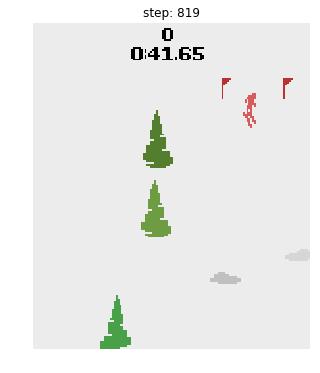

In [9]:
observe = env.reset()
done = False
history = np.concatenate([pre_processing(observe)] * n_cont, -1)

tmp_obs = [observe]
while not done:
  p = sess.run(p_hat, feed_dict={x: [history]})[0]
  act = np.random.choice(3, 1, p=p)[0]
  observe, reward, done, info = env.step(act)
  history = np.concatenate([pre_processing(observe), history[:,:,3:]], -1)
  tmp_obs.append(observe)

for i, o in enumerate(tmp_obs):
  if i % 3 == 0:
    render(o[:,:,:3][28:-52,8:152], i)
render(o[:,:,:3][28:-52,8:152], i)